# Exploratory analysis on 2016 US bike-share data

## Table of Contents
- [Introduction](#intro)
- [Posing Initial Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Future Enhancments](#future_enhancments)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. And I will also try to find out if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Initial Questions

Before looking at the data, I started by asking a few questions that I might want to understand about the bike-share data. 

Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

What is the average trip duration in each city?
What are the average distances between different docks?

1. Which city has the highest number of trips? 
2. Which city has the highest proportion of trips made by subscribers? 
3. Which city has the highest proportion of trips made by short-term customers?
4. What is the average trip length for each city?
5. What proportion of rides made in each city are longer than 30 minutes?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now I'll collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a CSV file in the `/data/` folder, each file has a random 2% sample of the original data is taken to make the exploration more manageable.

However, there is still a lot of data to investigate, so I'll start off by looking at one entry from each of the cities we're going to analyze.

In [1]:
# Import all necessary packages and functions
import csv # Read and write csv files
from datetime import datetime # Operations to parse dates
from pprint import pprint # Use to print data structures like dictionaries in
                          # a nicer way than the base print function
# import pandas as pd # For storing and manipulating data

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # Print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        # Use the csv library to set up a DictReader object
        trip_reader = csv.DictReader(f_in)

        # Use the next function on the DictReader object to read the first trip
        first_trip = next(trip_reader)
        
        # Use the pprint library to print the first trip
        pprint(first_trip)
        
    # Output city name and first trip for later testing
    return (city, first_trip)

# List of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# Print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

When you set up a `DictReader` object, the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It is observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. I'll use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. I'll be using the [`datetime`](https://docs.python.org/3/library/datetime.html) package to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.


I'll write some helper functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    """
    
    # Convert the strings into an integer and apply teh transfomations
    if city == 'Washington':
        duration = int(datum['Duration (ms)'])/60000
    else:
        duration = int(datum['tripduration'])/60
        
    return duration


# Some tests to check that the function works correctly. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    NYC includes seconds, while Washington and Chicago do not.
    """

    # Use datetime module to parse the original date strings
    if city == 'NYC':
        time = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M:%S')
    elif city == 'Chicago':
        time = datetime.strptime(datum['starttime'], '%m/%d/%Y %H:%M')
    elif city == 'Washington':
        time = datetime.strptime(datum['Start date'], '%m/%d/%Y %H:%M')
    
    month = int(time.strftime('%m'))
    hour = int(time.strftime('%H'))
    day_of_week = time.strftime('%A')
    
    return (month, hour, day_of_week)


# Some tests to check that the function works correctly. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Washington has different category names compared to Chicago
    and NYC. 
    """
    
    # Convert Washington user type stings
    if city == 'Washington':
        user_type = 'Subscriber' if datum['Member Type'] == 'Registered' else 'Customer'
    else:
        user_type = datum['usertype']
        
    return user_type


# Some tests to check that the function works correctly. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# I printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Now, I'm going to use the helper functions above to create a condensed data file for each city consisting only of the data fields indicated above.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # Set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        # Set up csv DictReader object
        trip_reader = csv.DictReader(f_in)

        # Collect data from and process each row
        for row in trip_reader:
            # Set up a dictionary to hold the values for the cleaned and trimmed data point
            new_point = {}

            ## Use the helper functions to get the cleaned data from the original dictionaries
            duration = duration_in_mins(row, city)
            month, hour, day_of_week = time_of_trip(row, city)
            user_type = type_of_user(row, city)
            new_point = {'duration':duration, 'month':month, 'hour':hour, 'day_of_week':day_of_week, 'user_type':user_type}
            
            # Write the processed information to the output file
            trip_writer.writerow(new_point)

In [7]:
# Set the file names for each city
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

# Run the condense_data helper function on each city and print the first point to test it out
for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that data has been collected and wrangled, I'll start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also be using the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the summary data that I created above.

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # Set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # Tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # Compute total number of rides
        n_total = n_subscribers + n_customers
        
        # Return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [9]:
# Run the number_of_trips function on the summary data files
city_info = {'Washington':'./data/Washington-2016-Summary.csv',
             'Chicago':'./data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}

for city, filename in city_info.items():
    n_subscribers, n_customers, n_total = number_of_trips(filename)
    ratio = n_subscribers/n_customers
    print(city, n_total, ratio)

Washington 66326 3.551293487957181
Chicago 72131 3.2061344684821274
NYC 276798 7.957284318167109


#### Answers for the first 3 questions:

1. Which city has the highest number of trips?
    - The city that has the highest number of trips is in NYC with 276798 trips
2. Which city has the highest proportion of trips made by subscribers?
    - The city that has the highest proportion of trips made by subscribers is NYC which is more than double the other cities
3. Which city has the highest proportion of trips made by short-term customers?
    - The city that has the highest proportion of trips made by short-term customers is Chicago
    
Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration.  So now I'll explore the trip durations in each city.

In [10]:
def trip_length(filename):
    """
    This function reads in a file with trip data and reports the average trip length
    and the proportion of rides made in each city are longer than 30 minutes.
    """
    with open(filename, 'r') as f_in:
        # Set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize count variables
        count = 0
        total_length = 0
        over_30 = 0
        
        # Tally up ride durations
        for row in reader:
            count += 1
            duration = float(row['duration'])
            total_length += duration
            if duration > 30:
                over_30 += 1
        
        # Compute the average trip length and proportion over 30
        average_trip_length = round(total_length / count, 2)
        proportion_over_30 = round((over_30 / count) * 100, 2)
        
        # Return tallies as a tuple
        return(average_trip_length, proportion_over_30)

In [11]:
# Run the trip_length function on the summary data files
city_info = {'Washington':'./data/Washington-2016-Summary.csv',
             'Chicago':'./data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}

for city, filename in city_info.items():
    average_trip_length, proportion_over_30 = trip_length(filename)
    print('For {0} the average trip length is {1} minutes and {2}% of trips are longer than 30 minutes'.format(city, average_trip_length, proportion_over_30))

For Washington the average trip length is 18.93 minutes and 10.84% of trips are longer than 30 minutes
For Chicago the average trip length is 16.56 minutes and 8.33% of trips are longer than 30 minutes
For NYC the average trip length is 15.81 minutes and 7.3% of trips are longer than 30 minutes


#### Answers for questions 4 and 5:

4. What is the average trip length for each city? and 5. What proportion of rides made in each city are longer than 30 minutes?
    - For Washington the average trip length is 18.93 minutes and 10.84% of trips are longer than 30 minutes
    - For Chicago the average trip length is 16.56 minutes and 8.33% of trips are longer than 30 minutes
    - For NYC the average trip length is 15.81 minutes and 7.3% of trips are longer than 30 minutes

Digging deeper into the question of trip duration based on ridership. I choose NYC to explore which type of user takes longer rides on average: Subscribers or Customers?

In [12]:
def average_trips_duration(filename):
    """
    This function reads in a file with trip data and reports the average
    trip duration made by subscribers, and customers.
    """
    with open(filename, 'r') as f_in:
        # Set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize count and duration variables
        n_subscribers = 0
        d_subscribers = 0
        n_customers = 0
        d_customers = 0
        
        # Tally up ride types with duration
        for row in reader:
            duration = float(row['duration'])
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
                d_subscribers += duration
            else:
                n_customers += 1
                d_customers += duration
        
        # Compute average duration of rides
        average_d_subscribers = round(d_subscribers / n_subscribers,2)
        average_d_customers = round(d_customers / n_customers,2)
        
        # Return tallies as a tuple
        return(average_d_subscribers, average_d_customers)

In [13]:
# Run the average_trips_duration function on the summary data files for NYC
NYC_data_file = './data/NYC-2016-Summary.csv'
average_d_subscribers, average_d_customers = average_trips_duration(NYC_data_file)
print('For NYC the average Subscriber trip duration is {0} minutes while the average Customer trip duration is {1} minutes.'.format(average_d_subscribers, average_d_customers))

For NYC the average Subscriber trip duration is 13.68 minutes while the average Customer trip duration is 32.78 minutes.


#### Answer: 
For NYC the average Subscriber trip duration is 13.68 minutes while the average Customer trip duration is 32.78 minutes.

<a id='visualizations'></a>
### Visualizations

While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting to look at how the trip times are distributed. In order to do this, I'll use the `matplotlib` library to generate the plots. As a first step I won't separate the Subscribers and Customers.

In [14]:
# Load library
import matplotlib.pyplot as plt

# Display plots inline with the notebook
%matplotlib inline 

In [15]:
def list_trips_duration(filename, user_type='Both'):
    """
    This function reads in a file with trip data and returns a list of 
    trip durations based on the user type.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # Initialize count variables
        durations = []
        
        # Tally up ride durations
        for row in reader:
            if user_type == 'Both':
                durations.append(float(row['duration']))
            elif user_type == row['user_type']:
                durations.append(float(row['duration']))
        
        # Return the durations list
        return durations

In the below cell, we ran the function to generate the list of trip durations, and passed this list as the first argument to the `.hist()` function. This function performs the computations and creates plotting objects for generating a histogram, but the plot is actually not rendered until the `.show()` function is executed. The `.title()` and `.xlabel()` functions provide some labeling for plot context.

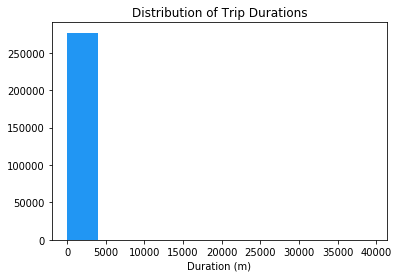

In [16]:
# Use pyplot functions to generate a histogram of the trip times
plt.hist(list_trips_duration(NYC_data_file), color='#2196F3')
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, I will use additional parameters with the `.hist()` function to limit the range of data that is plotted.

Also in the next plots I'll separate the Subscribers and Customers and limit the plots so that only trips of duration less than 75 minutes are plotted in five-minute wide intervals.

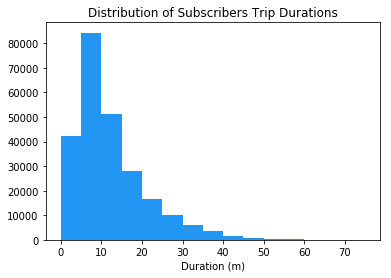

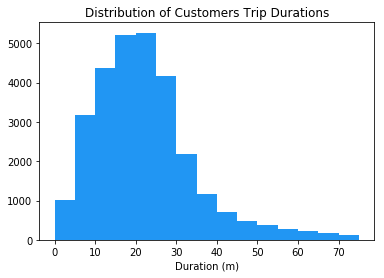

In [17]:
# Use pyplot functions to generate histograms of the trip times
plt.hist(list_trips_duration(NYC_data_file, 'Subscriber'),range=(0,75),bins=15, color='#2196F3')
plt.title('Distribution of Subscribers Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

plt.hist(list_trips_duration(NYC_data_file, 'Customer'),range=(0,75),bins=15, color='#2196F3')
plt.title('Distribution of Customers Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

#### Observation:
In NYC the peak of the Subscribers distribution is between 5 and 10 minutes, while the peak of the Customers distribution is between 20 and 25 mintues. Both distributions have a right-skewed bell shape curve.

So far, I've performed an initial exploration into the data available. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these NYC, I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now I'll further explore NYC to see if the pattern of ridership is different on the weekends versus weekdays? And if it is affected by the user types?

In [18]:
def daily_trips_duration_count(filename, user_type='Both'):
    """
    This function reads in a file with trip data and returns a Dictionary
    of the durations and number of trips for each day of the week based on
    the user type(s) selected.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        durations = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
        counts = {'Monday':0, 'Tuesday':0, 'Wednesday':0, 'Thursday':0, 'Friday':0, 'Saturday':0, 'Sunday':0}
        
        # tally up ride durations
        for row in reader:
            if user_type == 'Both':
                durations[row['day_of_week']] = durations[row['day_of_week']] + float(row['duration'])
                counts[row['day_of_week']] += 1
            elif user_type == row['user_type']:
                durations[row['day_of_week']] = durations[row['day_of_week']] + float(row['duration'])
                counts[row['day_of_week']] += 1

        # return the durations and count Dictionary
        return {k: (durations[k], counts[k]) for k in durations.keys() & counts.keys()}

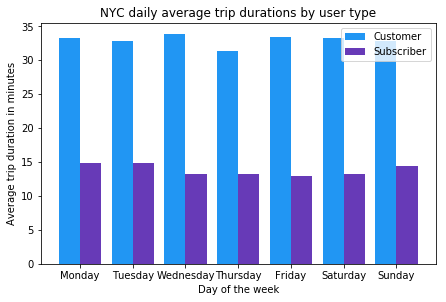

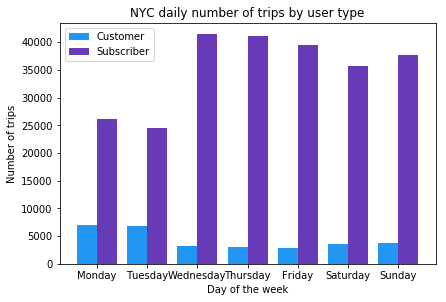

[[ 1.         -0.97387795]
 [-0.97387795  1.        ]]


In [19]:
# Import numpy module
import numpy as np

# Get daily average trips durations and count for each type of user
cutomer_trips = daily_trips_duration_count(NYC_data_file, 'Customer')
subscriber_trips = daily_trips_duration_count(NYC_data_file, 'Subscriber')

# Set number of groups for each day of the week
n_groups = 7

# Calculate the average trips durations for each type of user per day
cutomer_average_trips_durations = [cutomer_trips[k][0]/cutomer_trips[k][1] for k in cutomer_trips.keys()]
subscriber_average_trips_durations = [subscriber_trips[k][0]/subscriber_trips[k][1] for k in subscriber_trips.keys()]

fig, ax = plt.subplots()

# Set bar plots settings
index = np.arange(n_groups)
bar_width = 0.4

# Plot the bar plots in the same plot
rects1 = ax.bar(index, cutomer_average_trips_durations,
                bar_width, color='#2196F3', label='Customer')

rects2 = ax.bar(index + bar_width, subscriber_average_trips_durations,
                bar_width, color='#673AB7', label='Subscriber')

ax.set_xlabel('Day of the week')
ax.set_ylabel('Average trip duration in minutes')
ax.set_title('NYC daily average trip durations by user type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
ax.legend()

fig.tight_layout(pad=0.01)
plt.show()

# Calculate the number of trips for each type of user per day
cutomer_trips_count = [cutomer_trips[k][1] for k in cutomer_trips.keys()]
subscriber_trips_count = [subscriber_trips[k][1] for k in subscriber_trips.keys()]

fig, ax = plt.subplots()

# Plot the bar plots in the same plot
rects1 = ax.bar(index, cutomer_trips_count,
                bar_width, color='#2196F3', label='Customer')

rects2 = ax.bar(index + bar_width, subscriber_trips_count,
                bar_width, color='#673AB7', label='Subscriber')

ax.set_xlabel('Day of the week')
ax.set_ylabel('Number of trips')
ax.set_title('NYC daily number of trips by user type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
ax.legend()

fig.tight_layout(pad=0.01)
plt.show()

# Calculate and print the correaltion coefficient between the number of trips of different user types
print(np.corrcoef(cutomer_trips_count, subscriber_trips_count))

#### Observations:
- From the 'NYC daily average trip durations by user type' chart it is quite clear that even though the there is no significant variation between the average trip durations in relation to different days of the week, there is a huge difference between the average of each user type.

- After further investigation from the 'NYC daily number of trips by user type' chart, even though the average trip duration did not decease for both user types, there are some variations in the number of trips.

- After visually inspecting the pattern of variations in the number of trips from the bar chart, I had the feeling that there is a correlation between the changes in trip numbers between the user types. After calculating the correlation coefficient, it shows that there is a high negative correlation between the 2 user types (-0.97387795).

<a id='future_enhancments'></a>
## Future Enhancments

- Using Pandas module to enhance the workflow and avoid reloding the data from CSV files, this will also be much more efficient.
- Further investigation will be needed to understand the correlation. 
- Another pattern that might be worth exploring is the significant variations from the average on Thursdays and Sundays.
- Performing a statistical test or fitting the data to a model for making predictions.
- There are also a lot of potential analyses that could be performed on the data which are not possible with only the data provided. For example, detailed location data has not been investigated. Where are the most commonly used docks? What are the most common routes? As another example, weather has potential to have a large impact on daily ridership. How much is ridership impacted when there is rain or snow? Are subscribers or customers affected more by changes in weather?